Selected images: [12623, 13781, 1326, 8484, 16753]

Image 12623 (label 21), global top-k threshold: 2.0144


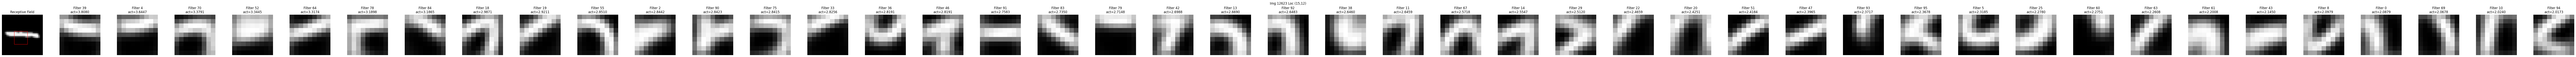

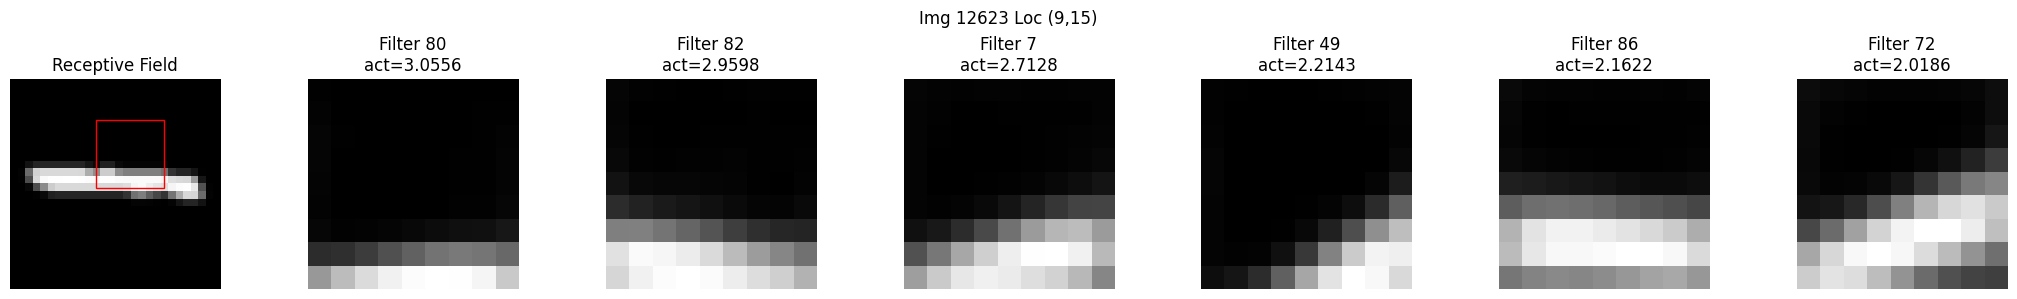

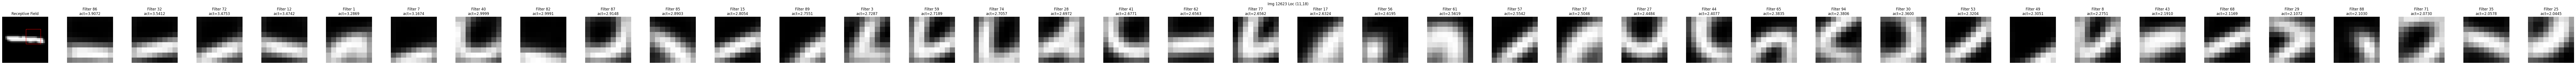

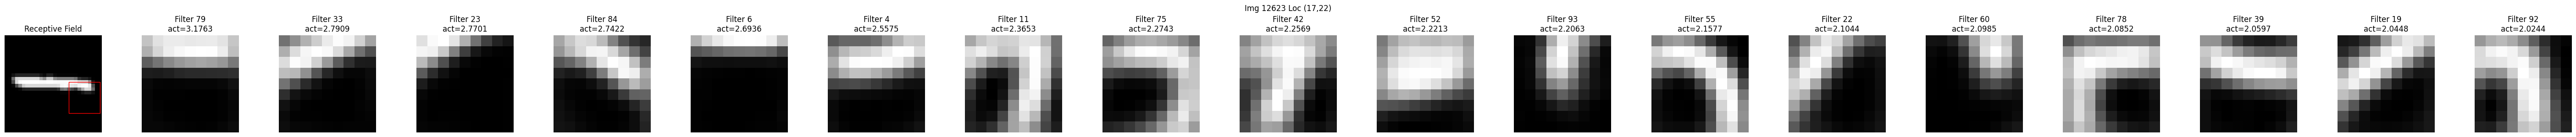

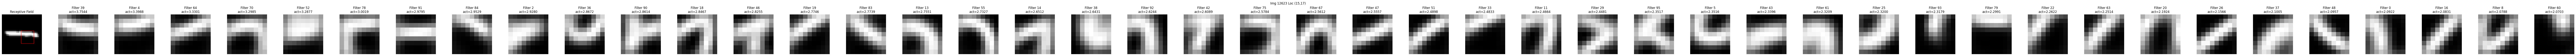


Image 13781 (label 41), global top-k threshold: 3.0407


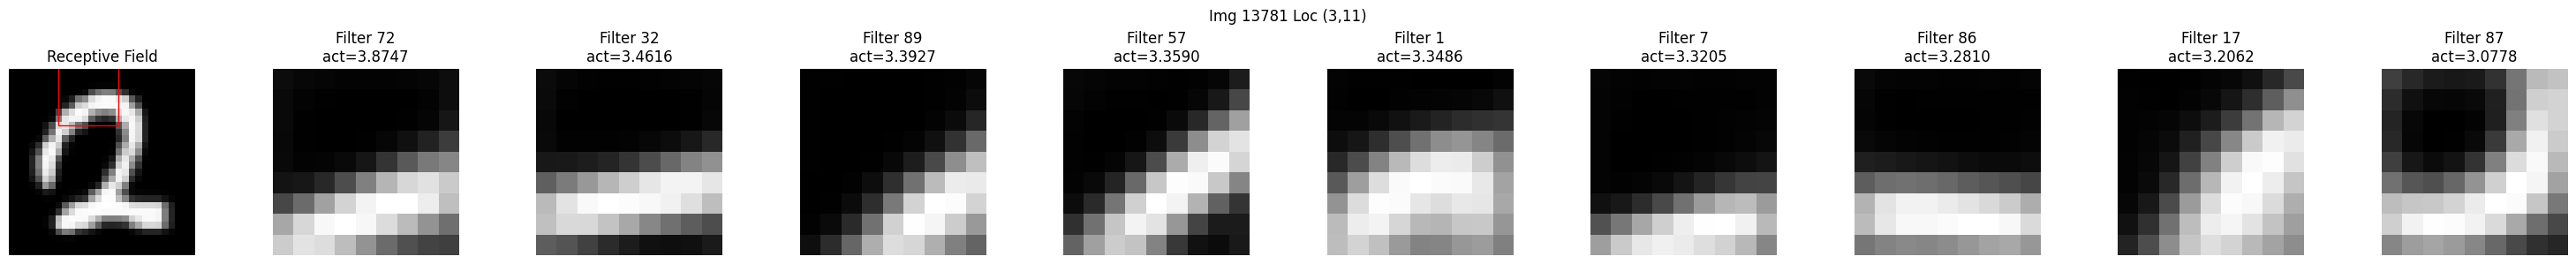

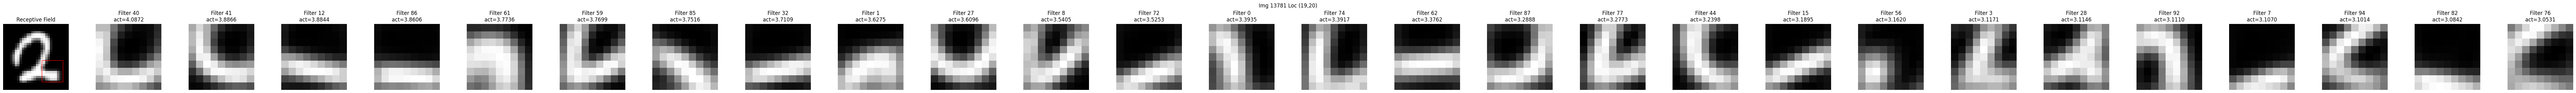

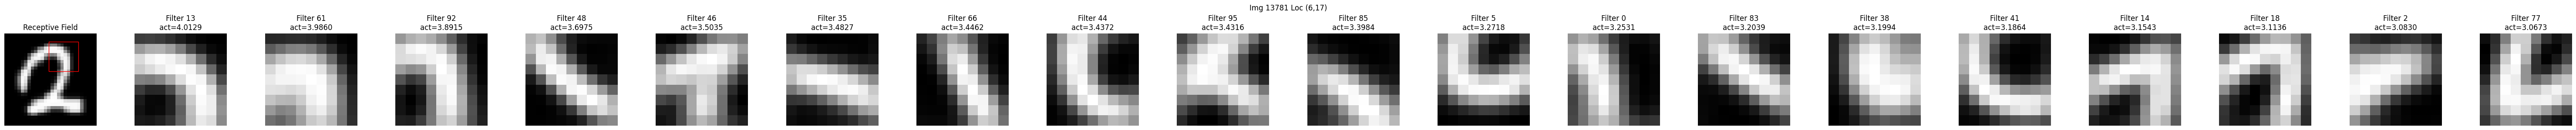

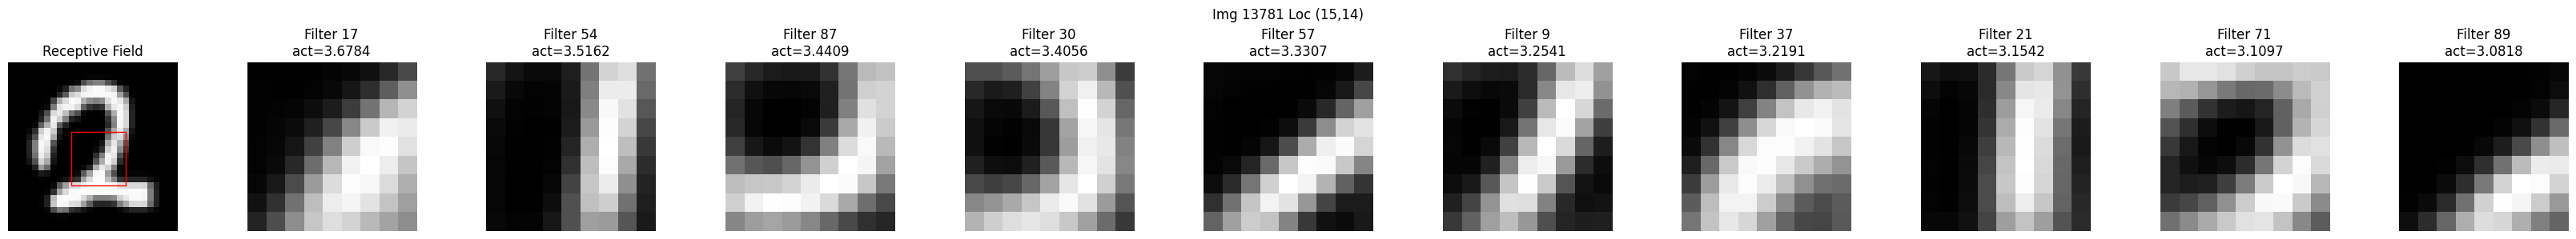

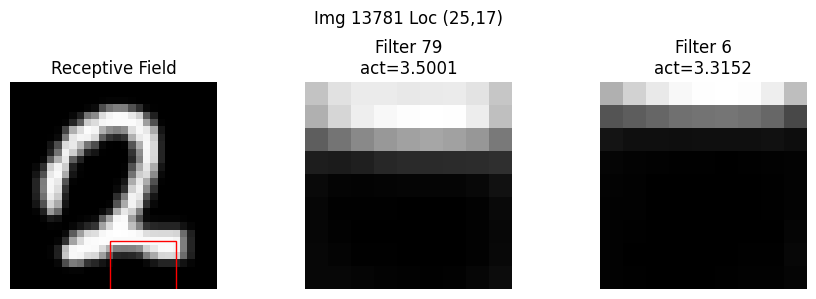


Image 1326 (label 45), global top-k threshold: 3.0614


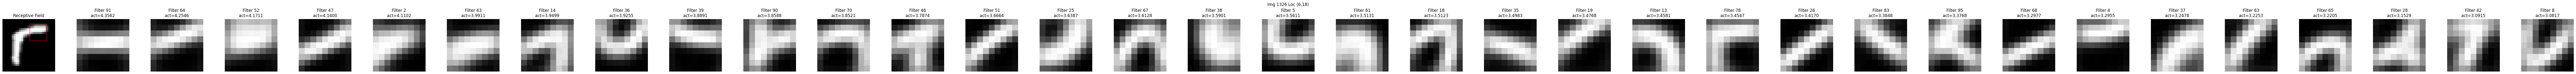

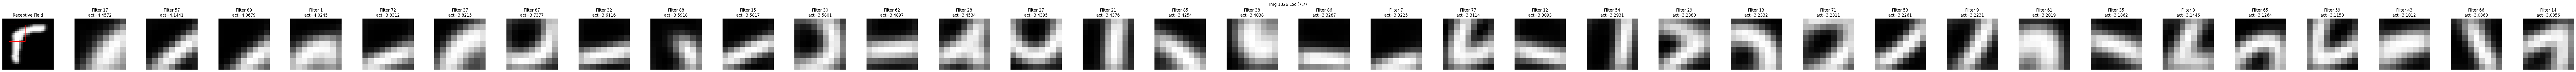

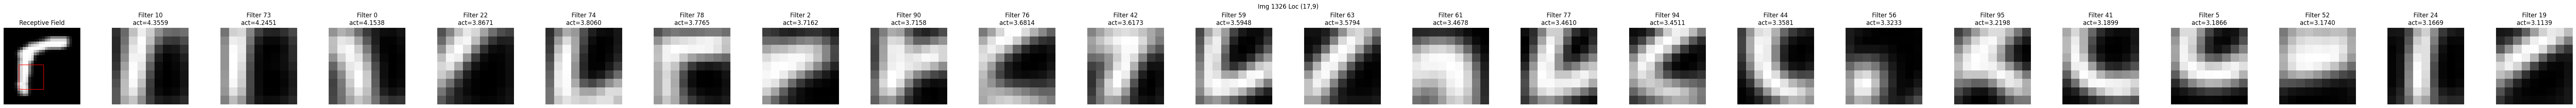

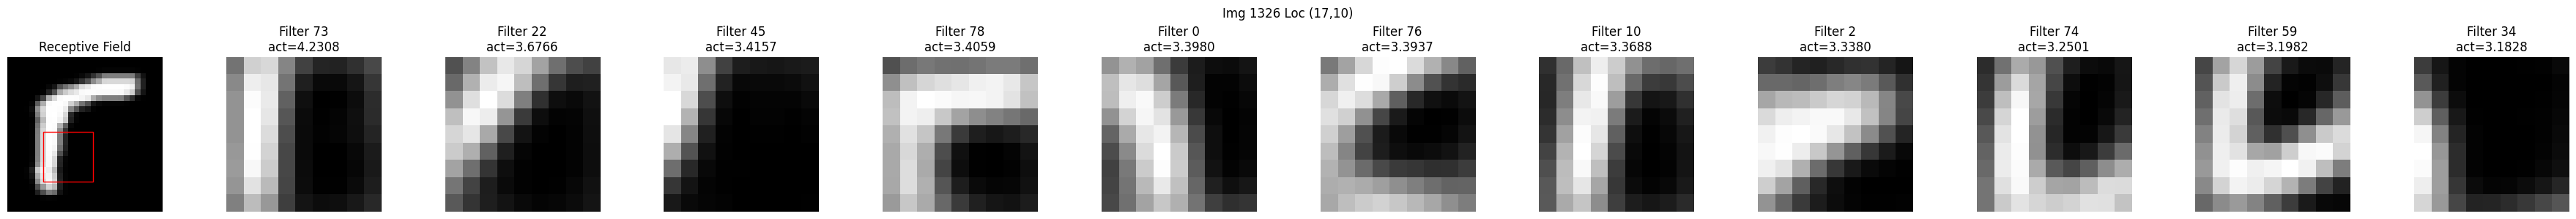

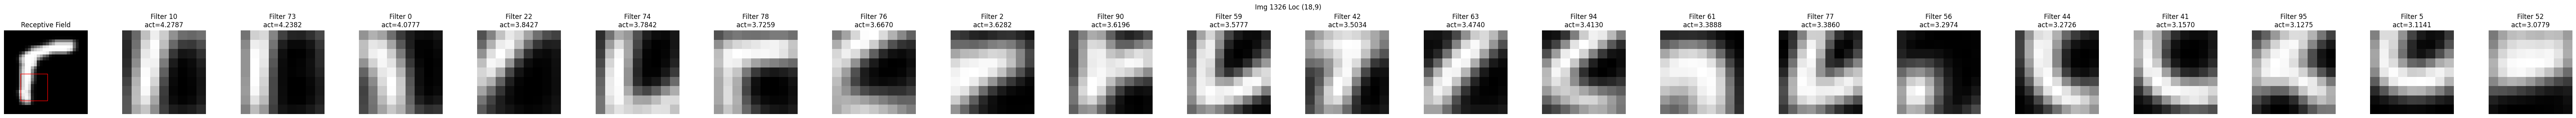


Image 8484 (label 41), global top-k threshold: 3.2607


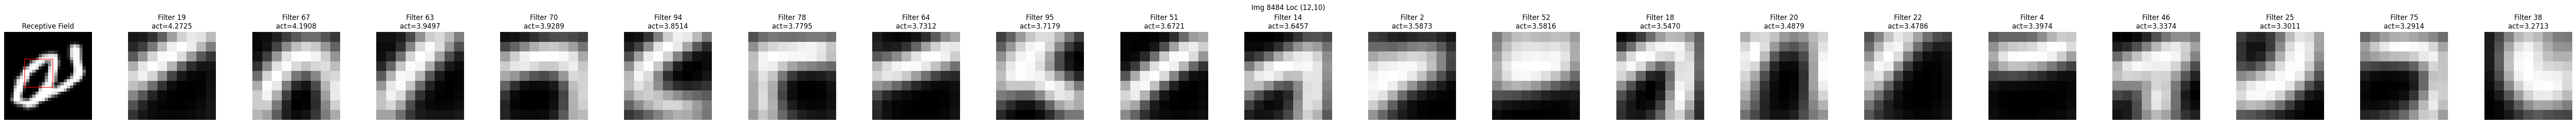

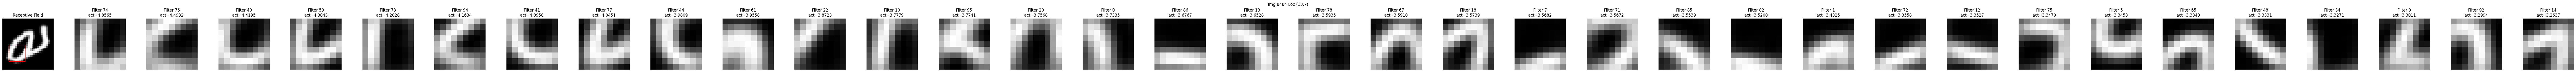

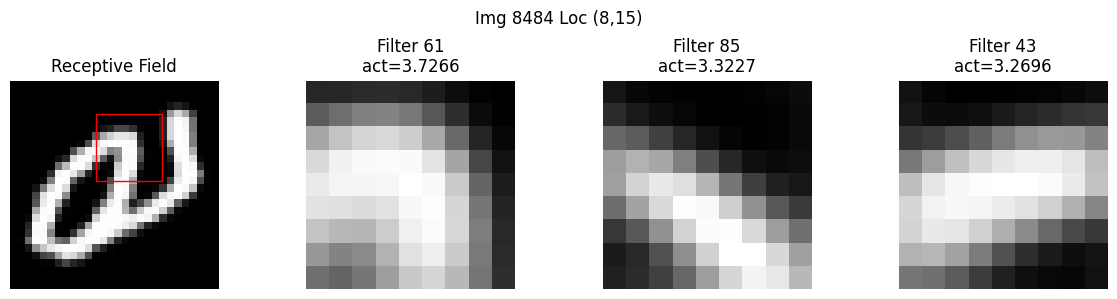

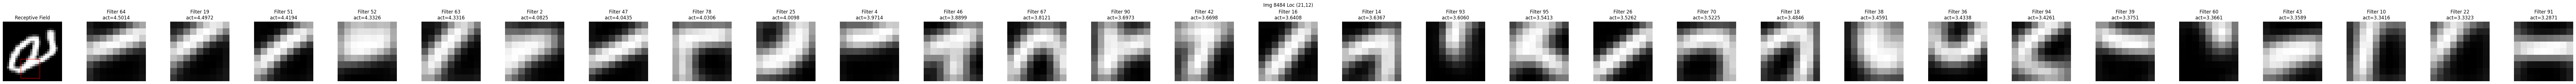

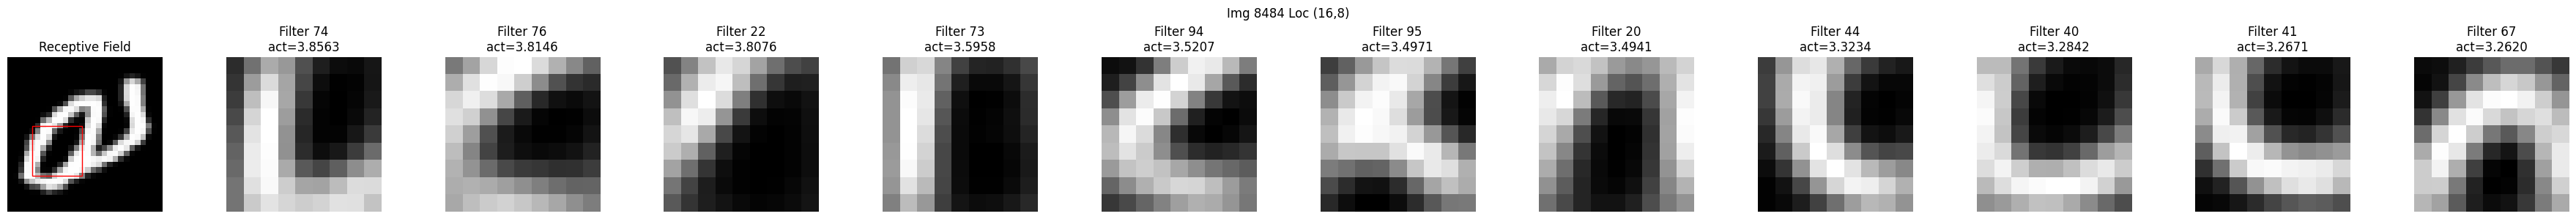


Image 16753 (label 34), global top-k threshold: 2.8992


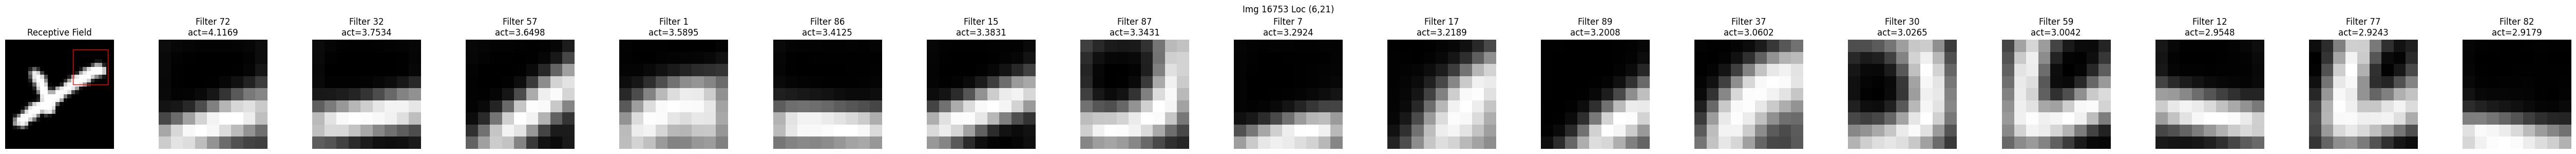

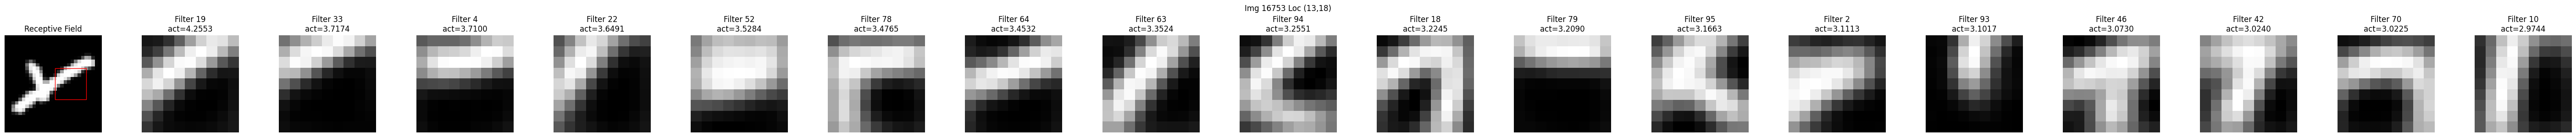

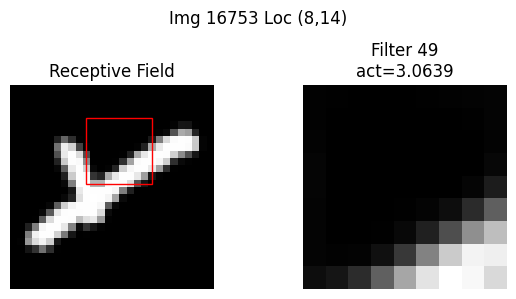

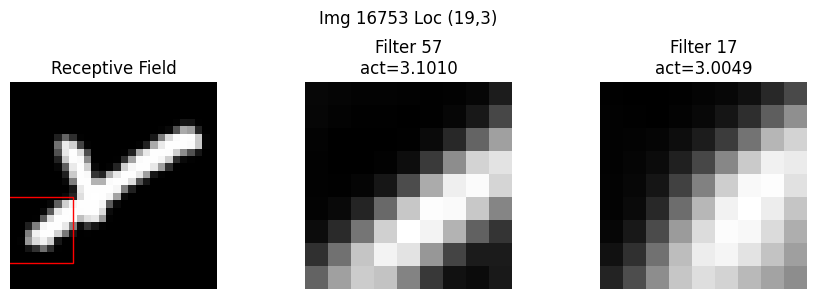

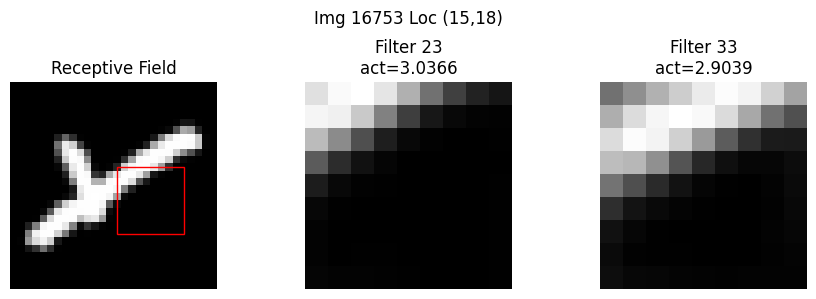

In [5]:
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import EMNIST
from torchvision import transforms
from omegaconf import OmegaConf
from src.models.trunk_i import TrunkI

# conv1_filter_analysis.py
# Visualize conv1 filter activations at random spatial locations
# Display only the actual filter kernels that pass the global top-k threshold
# and print their activation (inner product) values.

# --- Load config and model ---
cfg = OmegaConf.load('configs/i.yaml')  # adjust to your config path
model = TrunkI(cfg)
model.eval()
conv1 = model.conv1
filters = conv1.weight.detach().cpu().numpy().squeeze(1)  # (C, K, K)
C, K, _ = filters.shape
pad = K // 2

# --- Prepare EMNIST test set ---
transform = transforms.Compose([transforms.ToTensor()])
dataset = EMNIST('data', split='balanced', train=False, download=True, transform=transform)

# --- Parameters ---
NUM_IMAGES = 5  # number of random images to sample
NUM_LOCS = 5    # number of random locations per image
random.seed(0)
np.random.seed(0)

# --- Sample images ---
indices = random.sample(range(len(dataset)), NUM_IMAGES)
print(f"Selected images: {indices}")

for idx in indices:
    img, label = dataset[idx]
    x = img.unsqueeze(0)  # (1,1,H,W)
    H, W = img.shape[1:]

    # Compute conv1 activations
    with torch.no_grad():
        A = F.relu(conv1(x))  # (1, C, H, W)
    A_np = A[0].cpu().numpy()  # (C, H, W)

    # Compute global threshold
    flat_vals = A_np.flatten()
    k = max(1, int(math.ceil(cfg.model.global_topk_ratio * flat_vals.size)))
    threshold = np.sort(flat_vals)[-k]
    print(f"\nImage {idx} (label {label}), global top-k threshold: {threshold:.4f}")

    # Select locations with at least one passing filter
    locs = []
    tries = 0
    while len(locs) < NUM_LOCS and tries < NUM_LOCS * 10:
        h = random.randrange(H)
        w = random.randrange(W)
        acts = A_np[:, h, w]
        if (acts >= threshold).any():
            locs.append((h, w))
        tries += 1

    # Plot each selected location
    for (h, w) in locs:
        acts = A_np[:, h, w]
        passed = np.where(acts >= threshold)[0]
        # Sort passed filters by descending activation
        passed_sorted = passed[np.argsort(acts[passed])[::-1]]

        # 1) Show the image patch for this location
        fig, axes = plt.subplots(1, len(passed_sorted) + 1, figsize=(3*(len(passed_sorted)+1), 3))
        fig.suptitle(f"Img {idx} Loc ({h},{w})")

        # Original image with receptive field
        ax0 = axes[0]
        ax0.imshow(img.squeeze(), cmap='gray')
        rect = plt.Rectangle((w - pad, h - pad), K, K, edgecolor='red', facecolor='none')
        ax0.add_patch(rect)
        ax0.set_title('Receptive Field')
        ax0.axis('off')

        # Filter patches that passed
        for i, fidx in enumerate(passed_sorted):
            ax = axes[i + 1]
            ax.imshow(filters[fidx], cmap='gray', interpolation='nearest')
            ax.set_title(f"Filter {fidx}\nact={acts[fidx]:.4f}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()
